In this example we run through a simplified procedure to calculate the inter-molecular electronic coupling energies between penta-3-hexylthiophene

Procedure:
    * Generate models of thiophene and hexane based on based on quantum chemistry data from NWChem
    * Use streamm to create a 3-hexylthiophene pentamer
    * Replicate the pentamer into a periodic simulation cell
    * Anneal the system with LAMMPS
    * Calculate the inter-molecular electronic coupling using NWChem's electron transfer module 

In [1]:
import os 
from pprint import pprint

In [2]:
from pathlib2 import Path
import os

In [3]:
import csv 

In [4]:
import numpy as np
import decimal
import copy

In [5]:
import matplotlib
import matplotlib.pyplot as plt

In [6]:
%matplotlib inline

In [7]:
import time

Set wait time to check if calculation has finished

In [8]:
status_refresh = 1

In [9]:
import streamm

In this getting started example we will calculate the coupling between P3HT oligomers

In [10]:
import logging
logging.basicConfig(filename='p3ht_et.log',level=logging.DEBUG)

Load Resource objects from Resource example

In [11]:
need_files = ['local_res.json','remote_res.json']
for f in need_files:
    path = Path(f)
    if not path.is_file():
        print("Need to run resource_example.ipynb")
        os.system("jupyter nbconvert --to python  resource_example.ipynb")
        os.system("python resource_example.py")

In [12]:
res_local = streamm.Resource('local')

The calc resource can be changed to local or remote host resouce 

In [13]:
res_calc = streamm.Resource('remote')

In [14]:
res_local.import_json()
res_calc.import_json()

Create needed directories 

In [15]:
res_local.make_dir() 
res_calc.make_dir() 

Now let's create project and resource to keep track of our work

In [16]:
p3ht_et = streamm.Project('P3HT_ET')

Set the directory structure for the project 

In [17]:
p3ht_et.set_resource(res_local)

Explicitly create a thiophene molecule

In [18]:
bbTh = streamm.Buildingblock('thiophene')
symbols = ['C','C','C','C','S','H','H','H','H']
positions = [ ]
positions.append([-1.55498576,-1.91131218,-0.00081000])
positions.append([-0.17775976,-1.91131218,-0.00081000])
positions.append([0.34761524,-0.57904218,-0.00081000])
positions.append([-0.65884476,0.36101082,0.00000000])
positions.append([-2.16948076,-0.35614618,-0.00000800])
positions.append([-2.18966076,-2.79526518,-0.00132100])
positions.append([0.45389024,-2.80145418,-0.00106400])
positions.append([1.41682424,-0.35961818,-0.00138200])
positions.append([-0.51943676,1.44024682,0.00064700])
for i in range(len(symbols)):
    pt_i = streamm.Particle(symbol=symbols[i])
    pos_i = positions[i]
    bbTh.add_partpos(pt_i,pos_i)

Set the names of the terminal sites to be joined later

In [19]:
bbTh.particles[5].rsite = 'termcap'
bbTh.particles[6].rsite = 'funccap'
bbTh.particles[8].rsite = 'termcap'

Set some properties of the molecule to keep track of the parts

In [20]:
c_cnt =1
h_cnt =1

for pkey_i, particle_i  in bbTh.particles.iteritems():

    if( particle_i.symbol == 'C' ):
        particle_i.label = "C%d"%(c_cnt)
        particle_i.resname = "SCP2"
        particle_i.residue = 1

        c_cnt +=1 
    if( particle_i.symbol == 'S' ):
        particle_i.resname = "ThS"
        particle_i.residue = 2

    if( particle_i.symbol == 'H' ):
        particle_i.label = "H%d"%(h_cnt)
        particle_i.resname = "HA"
        particle_i.residue = 3

        h_cnt +=1 


Set the force-field type and guess some reasonable charges 

In [21]:
for pkey_i, particle_i  in bbTh.particles.iteritems():
    if( particle_i.symbol == 'C' ):
        particle_i.paramkey = 'CA'
        particle_i.charge = -0.025
    if( particle_i.symbol == 'S' ):
        particle_i.paramkey = 'S'
        particle_i.charge = -0.3
    if( particle_i.symbol == 'H' ):
        particle_i.paramkey = 'HA'
        particle_i.charge = 0.1

Check molecule is neutral 

In [22]:
total_charge = 0.0
for pkey_i, particle_i  in bbTh.particles.iteritems():
    total_charge += particle_i.charge
print total_charge

-2.77555756156e-17


Optimize structure with NWChem

But let's put it in a function this time

In [23]:
def nw_opt(project_i,bb_i,res_i):
    '''Optimize a streamm Buildingblock object with nwchem 
    
    '''
    calc_n =  len(project_i.calculations)     
    nwchem_i = streamm.NWChem('nw_opt_{}_calc_{}'.format(bb_i.tag,calc_n))
    print nwchem_i.tag 
    # Add thiophene structure 
    nwchem_i.strucC = copy.deepcopy(bb_i)
    # Set calculation to run on external resource
    nwchem_i.set_resource(res_i)
    # Make the local directories 
    nwchem_i.make_dir()
    #Change to the `launch` directory
    os.chdir(nwchem_i.dir['launch'])
    # Copy over templates
    nwchem_i.cp_file('templates','run',"nwchem_remote.pbs",'templates','launch')
    nwchem_i.cp_file('templates','nw',"nwchem.nw",'templates','launch')
    # Read in templates files 
    nwchem_i.load_str('templates','nw')        
    nwchem_i.load_str('templates','run')
    # Set calculation properties 
    nwchem_i.properties['basis'] = '6-31g'
    nwchem_i.properties['method'] = 'UHF'
    nwchem_i.properties['charge'] = 0
    nwchem_i.properties['spin_mult'] = 1
    nwchem_i.properties['task'] = 'SCF optimize'
    nwchem_i.properties['coord'] = nwchem_i.strucC.write_coord()
    # 
    pprint(nwchem_i.properties)
    # Replace <key> with properties value 
    nwchem_i.replacewrite_prop('nw','input','nw','%s.nw'%(nwchem_i.tag))
    nwchem_i.properties['input_nw'] = nwchem_i.files['input']['nw']
    nwchem_i.replacewrite_prop('run','scripts','run','%s.pbs'%(nwchem_i.tag))
    #
    nwchem_i.add_file('output','log',"%s.log"%(nwchem_i.tag))
    # Save details in .json files 
    os.chdir(nwchem_i.dir['home'])
    p3ht_et.export_json()
    # 
    os.chdir(nwchem_i.dir['launch'])
    # 
    nwchem_i.push()
    # 
    nwchem_i.run()
    # Add calculation to project
    project_i.add_calc(nwchem_i,deepcopy = True)
    # 
    return project_i 

In [24]:
p3ht_et = nw_opt(p3ht_et,bbTh,res_calc)

nw_opt_thiophene_calc_0
{u'allocation': u'orgopv',
 u'basis': '6-31g',
 u'charge': 0,
 'comp_key': 'compressed',
 'compress': 'tar -czf ',
 'compress_sufix': 'tgz',
 'coord': u'     C      -1.55498576      -1.91131218      -0.00081000 \n     C      -0.17775976      -1.91131218      -0.00081000 \n     C       0.34761524      -0.57904218      -0.00081000 \n     C      -0.65884476       0.36101082       0.00000000 \n     S      -2.16948076      -0.35614618      -0.00000800 \n     H      -2.18966076      -2.79526518      -0.00132100 \n     H       0.45389024      -2.80145418      -0.00106400 \n     H       1.41682424      -0.35961818      -0.00138200 \n     H      -0.51943676       1.44024682       0.00064700 \n',
 u'e-mail': u'tkemper@nrel.gov',
 u'exe_command': u'qsub ',
 u'feature': u'24core',
 u'finish_str': u'Total times  cpu:',
 u'maxiter': 100,
 u'method': 'UHF',
 u'nodes': 1,
 u'nproc': 24,
 u'pmem': 1500,
 u'ppn': 24,
 u'queue': u'short',
 u'scratch': u'/scratch/tkemper/nw_opt_thi

In [25]:
nwchem_i = p3ht_et.calculations['nw_opt_thiophene_calc_0']

Check status unit finished

In [26]:
nwchem_i.check()
print nwchem_i.meta['status'] 

finished


In [27]:
while( nwchem_i.meta['status'] != 'finished'):
    nwchem_i.check()
    time.sleep(status_refresh)    

In [28]:
print nwchem_i.meta['status']

finished


Store the results 

In [29]:
nwchem_i.store()

Download full log file for analysis

In [30]:
nwchem_i.pull()

In [31]:
os.chdir(nwchem_i.dir['launch'])

In [32]:
nwchem_i.analysis()

Print energies, just for fun

In [33]:
print nwchem_i.properties['energy'],nwchem_i.unit_conf['energy']

-551.190757406 Ha


Check that the positions of the structure have been optimized 

In [34]:
print bbTh.positions

[[ -1.55498576e+00  -1.91131218e+00  -8.10000000e-04]
 [ -1.77759760e-01  -1.91131218e+00  -8.10000000e-04]
 [  3.47615240e-01  -5.79042180e-01  -8.10000000e-04]
 [ -6.58844760e-01   3.61010820e-01   0.00000000e+00]
 [ -2.16948076e+00  -3.56146180e-01  -8.00000000e-06]
 [ -2.18966076e+00  -2.79526518e+00  -1.32100000e-03]
 [  4.53890240e-01  -2.80145418e+00  -1.06400000e-03]
 [  1.41682424e+00  -3.59618180e-01  -1.38200000e-03]
 [ -5.19436760e-01   1.44024682e+00   6.47000000e-04]]


In [35]:
bbTh.unit_conf['length']

u'ang'

In [36]:
print nwchem_i.strucC.positions

[[ -1.52905024e+00  -1.96222385e+00  -6.11050000e-04]
 [ -1.87311710e-01  -1.91419641e+00  -4.66760000e-04]
 [  3.42637680e-01  -5.70428160e-01   3.88200000e-05]
 [ -6.05117140e-01   3.80442720e-01   4.03810000e-04]
 [ -2.25044431e+00  -3.24165230e-01   1.68202000e-03]
 [ -2.16242498e+00  -2.82011122e+00  -2.84988000e-03]
 [  4.31099410e-01  -2.78806908e+00  -1.27520000e-03]
 [  1.39119019e+00  -3.53818160e-01  -6.53140000e-04]
 [ -4.82417750e-01   1.43967677e+00  -1.82662000e-03]]


In [37]:
nwchem_i.strucC.unit_conf['length']

u'ang'

Update positions with optimized geometry 

In [38]:
for pk,p in bbTh.particles.iteritems():
    bbTh.positions[pk] = nwchem_i.strucC.positions[pk]
    print pk,p.symbol,bbTh.positions[pk]

0 C [ -1.52905024e+00  -1.96222385e+00  -6.11050000e-04]
1 C [ -1.87311710e-01  -1.91419641e+00  -4.66760000e-04]
2 C [  3.42637680e-01  -5.70428160e-01   3.88200000e-05]
3 C [ -6.05117140e-01   3.80442720e-01   4.03810000e-04]
4 S [ -2.25044431e+00  -3.24165230e-01   1.68202000e-03]
5 H [-2.16242498 -2.82011122 -0.00284988]
6 H [  4.31099410e-01  -2.78806908e+00  -1.27520000e-03]
7 H [  1.39119019e+00  -3.53818160e-01  -6.53140000e-04]
8 H [-0.48241775  1.43967677 -0.00182662]


Store the results in a tar ball in the storage directory 

In [39]:
nwchem_i.store()

Now let us calculate the ESP charges to use in our forcefield 

Again let's make it a function

In [40]:
def nw_esp(project_i,bb_i,res_i):
    '''Calculate ESP charges of a streamm Buildingblock object with nwchem 
    
    '''
    calc_n =  len(project_i.calculations)     
    nwchem_esp = streamm.NWChem('nw_esp_{}_calc_{}'.format(bb_i.tag,calc_n))
    print(nwchem_esp.tag)
    # Add thiophene structure with optimized coordinates from previous calculation
    nwchem_esp.strucC = copy.deepcopy(bb_i)
    # Set calculation to run on external resource
    nwchem_esp.set_resource(res_i)
    # Add calculation to project
    project_i.add_calc(nwchem_esp)
    # Make the local directories 
    nwchem_esp.make_dir()
    # Change to the `launch` directory
    os.chdir(nwchem_esp.dir['launch'])
    #
    nwchem_esp.cp_file('templates','run',"nwchem_remote.pbs",'templates','launch')
    nwchem_esp.cp_file('templates','nw',"nwchem_esp.nw",'templates','launch')
    #
    nwchem_esp.load_str('templates','nw')        
    nwchem_esp.load_str('templates','run')
    # 
    nwchem_esp.properties['basis'] = '6-31g'
    nwchem_esp.properties['method'] = 'UHF'
    nwchem_esp.properties['charge'] = 0
    nwchem_esp.properties['spin_mult'] = 1
    nwchem_esp.properties['task'] = 'SCF'
    nwchem_esp.properties['coord'] = nwchem_esp.strucC.write_coord()

    pprint(nwchem_esp.properties)

    nwchem_esp.replacewrite_prop('nw','input','nw','%s.nw'%(nwchem_esp.tag))

    nwchem_esp.properties['input_nw'] = nwchem_esp.files['input']['nw']
    nwchem_esp.replacewrite_prop('run','scripts','run','%s.pbs'%(nwchem_esp.tag))

    nwchem_esp.add_file('output','log',"%s.log"%(nwchem_esp.tag))

    # Save details in .json files 

    os.chdir(nwchem_esp.dir['home'])
    nwchem_esp.export_json()

    os.chdir(nwchem_esp.dir['launch'])
    nwchem_esp.push()
    nwchem_esp.run()
    # Add calculation to project
    project_i.add_calc(nwchem_esp,deepcopy = True)
    # 
    return project_i 
    
    

In [41]:
p3ht_et = nw_esp(p3ht_et,bbTh,res_calc)

nw_esp_thiophene_calc_1
{u'allocation': u'orgopv',
 u'basis': '6-31g',
 u'charge': 0,
 'comp_key': 'compressed',
 'compress': 'tar -czf ',
 'compress_sufix': 'tgz',
 'coord': u'     C      -1.52905024      -1.96222385      -0.00061105 \n     C      -0.18731171      -1.91419641      -0.00046676 \n     C       0.34263768      -0.57042816       0.00003882 \n     C      -0.60511714       0.38044272       0.00040381 \n     S      -2.25044431      -0.32416523       0.00168202 \n     H      -2.16242498      -2.82011122      -0.00284988 \n     H       0.43109941      -2.78806908      -0.00127520 \n     H       1.39119019      -0.35381816      -0.00065314 \n     H      -0.48241775       1.43967677      -0.00182662 \n',
 u'e-mail': u'tkemper@nrel.gov',
 u'exe_command': u'qsub ',
 u'feature': u'24core',
 u'finish_str': u'Total times  cpu:',
 u'maxiter': 100,
 u'method': 'UHF',
 u'nodes': 1,
 u'nproc': 24,
 u'pmem': 1500,
 u'ppn': 24,
 u'queue': u'short',
 u'scratch': u'/scratch/tkemper/nw_esp_thi

Check status until finished

In [42]:
p3ht_et.check()

Calculation nw_esp_thiophene_calc_1 has status finished
Calculation nw_opt_thiophene_calc_0 has status stored


In [43]:
nwchem_i = p3ht_et.calculations['nw_esp_thiophene_calc_1']

In [44]:
os.chdir(nwchem_i.dir['launch'])

In [45]:
while( nwchem_i.meta['status'] != 'finished'):
    nwchem_i.check()
    time.sleep(status_refresh)    

Store the results 

In [46]:
nwchem_i.store()

Download full log file for analysis

In [47]:
nwchem_i.pull()

Run analysis to get the ESP charges

In [48]:
nwchem_i.analysis()

Check the new charges 

In [49]:
for pk,p in nwchem_i.strucC.particles.iteritems():
    print p.symbol, p.charge

C -0.086019
C -0.136647
C -0.085871
C -0.108869
S -0.117705
H 0.153867
H 0.118984
H 0.109177
H 0.153085


In [50]:
nwchem_i.strucC.calc_charge()
print nwchem_i.strucC.charge

2.00000000006e-06


A little extra charge can cause problems with our MD simulation so, if our total is not zero let's round and set to neutral 

In [51]:
def charges_round_neutral(strucC,ndigits = 2 ):
    total_charge = 0.0 
    for pk,p in strucC.particles.iteritems():
        p.charge = round(p.charge,ndigits)
        total_charge += p.charge
    #
    print total_charge
    #
    for pk,p in strucC.particles.iteritems():
        p.charge += -1.0*total_charge/strucC.n_particles 
    strucC.calc_charge()
    #
    print strucC.charge

In [52]:
if( abs(nwchem_i.strucC.charge) > 1.0e-16 ):
    charges_round_neutral(nwchem_i.strucC)

-0.02
8.32667268469e-17


Update the charges of the Buildingblock

In [53]:
bbTh.tag += '_HFesp'

In [54]:
print bbTh.tag

thiophene_HFesp


In [55]:
for pk,p in bbTh.particles.iteritems():
    p.charge = nwchem_i.strucC.particles[pk].charge
    print pk,p.symbol,p.charge

0 C -0.0877777777778
1 C -0.137777777778
2 C -0.0877777777778
3 C -0.107777777778
4 S -0.117777777778
5 H 0.152222222222
6 H 0.122222222222
7 H 0.112222222222
8 H 0.152222222222


Create the neighbor list and use it to set the bonds, bond angles and dihedrals for the force-field model

In [56]:
bbTh.bonded_nblist = bbTh.guess_nblist(0,radii_buffer=1.35)

In [57]:
bbTh.bonded_bonds()
bbTh.bonded_angles()
bbTh.bonded_dih()

Store an object of the Buildingblock

In [58]:
os.chdir(res_local.dir['materials']) 
th_json = bbTh.export_json()

Let us optimize the structure with the oplsaa force-field to check the parameters 

In [59]:
os.chdir(res_local.dir['home']) 

In [60]:
need_files = ['oplsaa_param.json']
for f in need_files:
    path = Path(f)
    if not path.is_file():
        print("Need to run forcefields_example.ipynb")
        os.system("jupyter nbconvert --to python  forcefields_example.ipynb")
        os.system("python forcefields_example.py")

In [61]:
oplsaa = streamm.Parameters('oplsaa')

In [62]:
oplsaa.import_json(read_file=True)

In [63]:
print oplsaa


    Parameters 
      LJ parameters 2 
      Bond parameters 2 
      Angle parameters 2 
      Dihedral parameters 1 
      Improper Dihedral parameters 0 



In [64]:
print oplsaa.unit_conf['energy']

kCalmol


We need to add the conjugated carbons, hydrogen and sulfur atom types 

In [65]:
import streamm.forcefields.particletype as particletype

In [66]:
import pymatgen_core.core.periodic_table as periodic_table

Set some parameters from J. Am. Chem. Soc., 1996, 118 (45), pp 11225–11236

In [67]:
CA = particletype.Particletype('CA')
HA = particletype.Particletype('HA')

In [68]:
CA.update_units(oplsaa.unit_conf)
HA.update_units(oplsaa.unit_conf)

In [69]:
CA.epsilon = 0.070 # kcal/mol
CA.sigma = 3.55 # Angstroms 

In [70]:
HA.epsilon = 0.030 # kcal/mol
HA.sigma = 2.42 # Angstroms 

In [71]:
CA.mass =  periodic_table.Element['C'].atomic_mass.real
HA.mass =  periodic_table.Element['H'].atomic_mass.real

In [72]:
print CA,HA

 CA epsilon:0.07 sigma:3.55  HA epsilon:0.03 sigma:2.42


In [73]:
S = particletype.Particletype('S')

In [74]:
S.update_units(oplsaa.unit_conf)

Set some parameters from J. Am. Chem. Soc., 1996, 118 (45), pp 11225–11236

In [75]:
S.epsilon = 0.25 # kcal/mol
S.sigma = 3.55 # Angstroms 

In [76]:
S.mass =  periodic_table.Element['S'].atomic_mass.real

Add to forcefield parameters container

In [77]:
oplsaa.add_particletype(CA)
oplsaa.add_particletype(HA)
oplsaa.add_particletype(S)

Set the bond stretching parameters 

In [78]:
import streamm.forcefields.bondtype as bondtype

In [79]:
bt_i = bondtype.Bondtype('CA','HA',unit_conf=oplsaa.unit_conf)
bt_i.setharmonic(1.080,367.0)
oplsaa.add_bondtype(bt_i)

In [80]:
bt_i = bondtype.Bondtype('CA','CA',unit_conf=oplsaa.unit_conf)
bt_i.setharmonic(1.400,469.0)
oplsaa.add_bondtype(bt_i)

In [81]:
bt_i = bondtype.Bondtype('S','CA',unit_conf=oplsaa.unit_conf)
bt_i.setharmonic(1.71,250.0)
oplsaa.add_bondtype(bt_i)

In [82]:
for btk,bt in oplsaa.bondtypes.iteritems():
    print btk,bt

0  bond  CT - HC type harmonic 
  harmonic r_0 = 1.080000 K = 367.000000 lammps index 0  gromacs index 0  
1  bond  CT - CT type harmonic 
  harmonic r_0 = 1.530000 K = 268.000000 lammps index 0  gromacs index 0  
2  bond  CA - HA type harmonic 
  harmonic r_0 = 1.080000 K = 367.000000 lammps index 0  gromacs index 0  
3  bond  CA - CA type harmonic 
  harmonic r_0 = 1.400000 K = 469.000000 lammps index 0  gromacs index 0  
4  bond  S - CA type harmonic 
  harmonic r_0 = 1.710000 K = 250.000000 lammps index 0  gromacs index 0  


In [83]:
import streamm.forcefields.angletype as angletype

In [84]:
bat_i = angletype.Angletype('CA','CA','CA',unit_conf=oplsaa.unit_conf)
bat_i.setharmonic(120.0,63.0)
oplsaa.add_angletype(bat_i)

In [85]:
bat_i = angletype.Angletype('CA','CA','HA',unit_conf=oplsaa.unit_conf)
bat_i.setharmonic(120.0,35.0)
oplsaa.add_angletype(bat_i)

In [86]:
bat_i = angletype.Angletype('CA','S','CA',unit_conf=oplsaa.unit_conf)
bat_i.setharmonic(92.2,70.0)
oplsaa.add_angletype(bat_i)

In [87]:
bat_i = angletype.Angletype('S','CA','HA',unit_conf=oplsaa.unit_conf)
bat_i.setharmonic(120.0,35.0)
oplsaa.add_angletype(bat_i)

In [88]:
bat_i = angletype.Angletype('S','CA','CA',unit_conf=oplsaa.unit_conf)
bat_i.setharmonic(111.0,70.0)
oplsaa.add_angletype(bat_i)

In [89]:
for atk,at in oplsaa.angletypes.iteritems():
    print atk,at

0  angle  HC - CT - HC type harmonic 
  harmonic theta_0 = 110.700000 K = 37.500000 lammps index 0  gromacs index 0  
1  angle  HC - CT - CT type harmonic 
  harmonic theta_0 = 110.700000 K = 37.500000 lammps index 0  gromacs index 0  
2  angle  CA - CA - CA type harmonic 
  harmonic theta_0 = 120.000000 K = 63.000000 lammps index 0  gromacs index 0  
3  angle  CA - CA - HA type harmonic 
  harmonic theta_0 = 120.000000 K = 35.000000 lammps index 0  gromacs index 0  
4  angle  CA - S - CA type harmonic 
  harmonic theta_0 = 92.200000 K = 70.000000 lammps index 0  gromacs index 0  
5  angle  S - CA - HA type harmonic 
  harmonic theta_0 = 120.000000 K = 35.000000 lammps index 0  gromacs index 0  
6  angle  S - CA - CA type harmonic 
  harmonic theta_0 = 111.000000 K = 70.000000 lammps index 0  gromacs index 0  


Set some reasonable dihedral parameters

In [90]:
import streamm.forcefields.dihtype as dihtype

In [91]:
dih_i = dihtype.Dihtype('X','CA','CA','X',unit_conf=oplsaa.unit_conf)
dih_i.type ='opls'
dih_i.setopls(0.0,1.812532,0.0,0.0)
oplsaa.add_dihtype(dih_i)

In [92]:
dih_i = dihtype.Dihtype('X','S','CA','X',unit_conf=oplsaa.unit_conf)
dih_i.type ='opls'
dih_i.setopls(0.0,2.416710,0.0,0.0)
oplsaa.add_dihtype(dih_i)

In [93]:
dih_i = dihtype.Dihtype('S','CA','CA','HA',unit_conf=oplsaa.unit_conf)
dih_i.type ='opls'
dih_i.setopls(0.0,1.812532,0.0,0.0)
oplsaa.add_dihtype(dih_i)

In [94]:
for dk,d in oplsaa.dihtypes.iteritems():
    print dk,d 

0  dihedral  HC - CT - CT - HC type opls 
  k1 = 0.000000 k2 = 0.000000 k3 = 0.300000 k4 = 0.000000 lammps index 0  gromcas index 0 
1  dihedral  X - CA - CA - X type opls 
  k1 = 0.000000 k2 = 1.812532 k3 = 0.000000 k4 = 0.000000 lammps index 0  gromcas index 0 
2  dihedral  X - S - CA - X type opls 
  k1 = 0.000000 k2 = 2.416710 k3 = 0.000000 k4 = 0.000000 lammps index 0  gromcas index 0 
3  dihedral  S - CA - CA - HA type opls 
  k1 = 0.000000 k2 = 1.812532 k3 = 0.000000 k4 = 0.000000 lammps index 0  gromcas index 0 


Let us make an MD simulation of just the monomer to check that our parameters are okay

In [95]:
def lmp_run(project_i,bb_i,param_i,res_i,md_type = 'min'):
    # Create LAMMPS calculation object 
    calc_n =  len(project_i.calculations)     
    lmp_i = streamm.LAMMPS('lmp_{}_{}_calc_{}'.format(md_type,bb_i.tag,calc_n))
    # lmp_i = streamm.LAMMPS('lmp_{}_{}'.format(md_type,bb_i.tag))
    # Set parameter container 
    lmp_i.paramC = param_i
    lmp_i.set_strucC(bb_i)
    # Set force-field parameters 
    lmp_i.set_ffparam()
    # Set resource to local
    lmp_i.set_resource(res_i)
    # Make local directories
    lmp_i.make_dir()
    # Set pbc's to on
    lmp_i.strucC.lat.pbcs = [True,True,True]
    # Change to launch directory
    os.chdir(lmp_i.dir['launch'])
    # Copy over the templates from the template directory 
    lmp_i.cp_file('templates','in',"lammps_{}.in".format(md_type),'templates','launch')
    lmp_i.cp_file('templates','run',"lammps_remote.pbs",'templates','launch')
    # Change to scratch
    os.chdir(lmp_i.dir['launch'])
    # Read in template files and store them as strings in the `str` dictionary
    lmp_i.load_str('templates','in')
    lmp_i.load_str('templates','run')
    # Write LAMMPS .data file
    lmp_i.write_data()
    # Replace keys in template string with properties 
    lmp_i.replacewrite_prop('in','input','in','%s.in'%(lmp_i.tag))
    # Add the input file to the properties to be written into the run file
    lmp_i.properties['input_in'] = lmp_i.files['input']['in']
    lmp_i.replacewrite_prop('run','scripts','run','%s.pbs'%(lmp_i.tag))
    # Save json file in root directory
    os.chdir(lmp_i.dir['home'])
    lmp_i.export_json()
    # Run bash script or submit to cluster
    lmp_i.add_file('output','log',"%s.log"%(lmp_i.tag))
    # Save details in .json files 
    os.chdir(lmp_i.dir['home'])
    project_i.export_json()
    lmp_i.export_json()
    #
    os.chdir(lmp_i.dir['launch'])
    lmp_i.push()
    lmp_i.run()
    # Add calculation to project
    project_i.add_calc(lmp_i,deepcopy = True)
    # 
    return project_i     

In [96]:
p3ht_et.check()

Calculation nw_esp_thiophene_calc_1 has status stored
Calculation nw_opt_thiophene_calc_0 has status stored


In [97]:
p3ht_et = lmp_run(p3ht_et,bbTh,oplsaa,res_calc)

In [98]:
lmp_i = p3ht_et.calculations['lmp_min_thiophene_HFesp_calc_2']

In [99]:
os.chdir(lmp_i.dir['launch'])

In [100]:
while( lmp_i.meta['status'] != 'finished'):
    lmp_i.check()
    time.sleep(status_refresh)    

Run analysis of .in and .log files 

In [101]:
lmp_i.analysis()

In [102]:
run_i= lmp_i.run_list[0]
print run_i.timeseries['toteng']

[15.543773, 7.7375745]


Energy decreased and nothing exploded so that's good

In [103]:
lmp_i.store()

Read in data file positions

In [104]:
lmp_i.pull()

Read in data file output and update positions

In [105]:
datafn = lmp_i.files['output']['data_1']
print datafn

min1.data


In [106]:
lmp_i.read_data_pos(datafn)

In [107]:
print lmp_i.strucC.lat.matrix

[[ 100.    0.    0.]
 [   0.  100.    0.]
 [   0.    0.  100.]]


In [108]:
lmp_i.strucC.write_xyz()

We will use the oplsaa optimized structure as the initial structure since we will be running MD 

In [109]:
bbTh.tag += '_oplsaa'

In [110]:
for pk,p in bbTh.particles.iteritems():
    bbTh.positions[pk] = lmp_i.strucC.positions[pk]
    print pk,p.symbol,bbTh.positions[pk]

0 C [ -1.56860038e+00  -1.93713397e+00  -1.24273622e-03]
1 C [ -1.72701660e-01  -1.89176169e+00  -1.60495164e-03]
2 C [ 0.33787844 -0.59671672 -0.00115104]
3 C [ -6.51342119e-01   3.89236583e-01  -4.03568474e-04]
4 S [ -2.21162214e+00  -3.39574867e-01  -2.15216875e-04]
5 H [ -2.16015039e+00  -2.84188201e+00  -1.58458414e-04]
6 H [  4.46480869e-01  -2.77679556e+00  -1.26658112e-03]
7 H [  1.39443300e+00  -3.72550668e-01  -5.03989719e-04]
8 H [ -4.66214626e-01   1.45428691e+00   9.88545095e-04]


Save the Buildingblock and force-field

In [111]:
os.chdir(res_local.dir['materials']) 
bbTh.write_xyz()
th_json = bbTh.export_json() 
oplsaa_json = oplsaa.export_json()

Okay now that we have a handle on thiophene let's follow the same procedure for hexane

Build hexane

In [112]:
bbHex = streamm.Buildingblock('hexane')
symbols = ['C','H','H','H','C','H','H','C','H','H','C','H','H','C','H','H','C','H','H','H']
positions = [ ]
positions.append([-6.410969,-0.381641,-0.000031])
positions.append([-7.310084,0.245311,-0.000038])
positions.append([-6.456117,-1.028799,0.884636])
positions.append([-6.456111,-1.028812,-0.884689])
positions.append([-5.135268,0.467175,-0.000033])
positions.append([-5.135484,1.128782,0.877977])
positions.append([-5.135479,1.128771,-0.87805])
positions.append([-3.850566,-0.371258,-0.000024])
positions.append([-3.85112,-1.033978,0.87841])
positions.append([-3.851114,-1.033987,-0.878451])
positions.append([-2.567451,0.469603,-0.000024])
positions.append([-2.567784,1.132155,0.8784])
positions.append([-2.567776,1.132146,-0.878455])
positions.append([-1.283527,-0.370234,-0.000013])
positions.append([-1.28337,-1.032804,0.87836])
positions.append([-1.28336,-1.032812,-0.87838])
positions.append([0.00482234,0.47342231,-0.00000898])
positions.append([0.02595107,1.09220686,0.87266464])
positions.append([0.85585781,-0.17514133,0.00194589])
positions.append([0.02780957,1.08937798,-0.87463473])
for i in range(len(symbols)):
    pt_i = streamm.Particle(symbol=symbols[i])
    pos_i = positions[i]
    bbHex.add_partpos(pt_i,pos_i)

In [113]:
bbHex.particles[0].rsite = 'rg'
bbHex.particles[1].rsite = 'rgcap'

In [114]:
c_cnt =1
h_cnt =1
for pkey_i, particle_i  in bbHex.particles.iteritems():
            if( particle_i.symbol == 'C' ):
                particle_i.label = "C%d"%(c_cnt)
                particle_i.resname = "SCP3"
                particle_i.residue = c_cnt
                c_cnt +=1 
            if( particle_i.symbol == 'H' ):
                particle_i.label = "H%d"%(h_cnt)
                particle_i.resname = "HC"
                particle_i.residue = c_cnt -1 
                h_cnt +=1 

Set the parameter keys and some reasonable atomic charges 

In [115]:
for pkey_i, particle_i  in bbHex.particles.iteritems():
            if( particle_i.symbol == 'C' ):
                particle_i.paramkey = 'CT'
                particle_i.charge = -0.12

            if( particle_i.symbol == 'H' ):
                particle_i.paramkey = 'HC'
                particle_i.charge = 0.06
            print pkey_i, particle_i.symbol,particle_i.charge

0 C -0.12
1 H 0.06
2 H 0.06
3 H 0.06
4 C -0.12
5 H 0.06
6 H 0.06
7 C -0.12
8 H 0.06
9 H 0.06
10 C -0.12
11 H 0.06
12 H 0.06
13 C -0.12
14 H 0.06
15 H 0.06
16 C -0.12
17 H 0.06
18 H 0.06
19 H 0.06


In [116]:
bbHex.particles[0].charge  = -0.18
bbHex.particles[16].charge  = -0.18

Check that the molecule is neutral 

In [117]:
bbHex.calc_charge()
print bbHex.charge


0.0


Now let us optimize and calculate ESP charges for hexane

Optimize structure with NWChem

In [118]:
print p3ht_et.calculations.keys()

['lmp_min_thiophene_HFesp_calc_2', 'nw_esp_thiophene_calc_1', 'nw_opt_thiophene_calc_0']


In [119]:
p3ht_et = nw_opt(p3ht_et,bbHex,res_calc)

nw_opt_hexane_calc_3
{u'allocation': u'orgopv',
 u'basis': '6-31g',
 u'charge': 0,
 'comp_key': 'compressed',
 'compress': 'tar -czf ',
 'compress_sufix': 'tgz',
 'coord': u'     C      -6.41096900      -0.38164100      -0.00003100 \n     H      -7.31008400       0.24531100      -0.00003800 \n     H      -6.45611700      -1.02879900       0.88463600 \n     H      -6.45611100      -1.02881200      -0.88468900 \n     C      -5.13526800       0.46717500      -0.00003300 \n     H      -5.13548400       1.12878200       0.87797700 \n     H      -5.13547900       1.12877100      -0.87805000 \n     C      -3.85056600      -0.37125800      -0.00002400 \n     H      -3.85112000      -1.03397800       0.87841000 \n     H      -3.85111400      -1.03398700      -0.87845100 \n     C      -2.56745100       0.46960300      -0.00002400 \n     H      -2.56778400       1.13215500       0.87840000 \n     H      -2.56777600       1.13214600      -0.87845500 \n     C      -1.28352700      -0.37023400      

In [120]:
p3ht_et.check()

Calculation nw_opt_hexane_calc_3 has status finished
Calculation lmp_min_thiophene_HFesp_calc_2 has status stored
Calculation nw_esp_thiophene_calc_1 has status stored
Calculation nw_opt_thiophene_calc_0 has status stored


In [121]:
nwchem_i = p3ht_et.calculations['nw_opt_hexane_calc_3']

In [122]:
os.chdir(nwchem_i.dir['launch'])

In [123]:
while( nwchem_i.meta['status'] != 'finished'):
    nwchem_i.check()
    time.sleep(status_refresh)

Store the results 

In [124]:
nwchem_i.store()

Download full log file for analysis

In [125]:
nwchem_i.pull()

Get the calculation from the project object 

In [126]:
nwchem_i.analysis()

Print energies 

In [127]:
print nwchem_i.properties['alpha_energies'][10:20]
print nwchem_i.properties['energy']

[-0.5549424, -0.5282407, -0.5218841, -0.4996812, -0.4774207, -0.4626707, -0.453462, -0.4506618, -0.4351213, 0.2272358]
-235.271544596


Check that the positions of the structure have been optimized 

In [128]:
for pk,p in bbHex.particles.iteritems():
    print pk,p.symbol,bbHex.positions[pk]

0 C [ -6.41096900e+00  -3.81641000e-01  -3.10000000e-05]
1 H [ -7.31008400e+00   2.45311000e-01  -3.80000000e-05]
2 H [-6.456117 -1.028799  0.884636]
3 H [-6.456111 -1.028812 -0.884689]
4 C [ -5.13526800e+00   4.67175000e-01  -3.30000000e-05]
5 H [-5.135484  1.128782  0.877977]
6 H [-5.135479  1.128771 -0.87805 ]
7 C [ -3.85056600e+00  -3.71258000e-01  -2.40000000e-05]
8 H [-3.85112  -1.033978  0.87841 ]
9 H [-3.851114 -1.033987 -0.878451]
10 C [ -2.56745100e+00   4.69603000e-01  -2.40000000e-05]
11 H [-2.567784  1.132155  0.8784  ]
12 H [-2.567776  1.132146 -0.878455]
13 C [ -1.28352700e+00  -3.70234000e-01  -1.30000000e-05]
14 H [-1.28337  -1.032804  0.87836 ]
15 H [-1.28336  -1.032812 -0.87838 ]
16 C [  4.82234000e-03   4.73422310e-01  -8.98000000e-06]
17 H [ 0.02595107  1.09220686  0.87266464]
18 H [ 0.85585781 -0.17514133  0.00194589]
19 H [ 0.02780957  1.08937798 -0.87463473]


In [129]:
print nwchem_i.strucC.positions

[[ -6.40727096e+00  -3.79022800e-01   3.48200000e-05]
 [ -7.29437061e+00   2.44910680e-01   7.42400000e-05]
 [ -6.45166132e+00  -1.01740711e+00   8.76562180e-01]
 [ -6.45174258e+00  -1.01732205e+00  -8.76555670e-01]
 [ -5.13169157e+00   4.68167580e-01   1.40700000e-05]
 [ -5.13055152e+00   1.11968843e+00   8.70404110e-01]
 [ -5.13070047e+00   1.11990884e+00  -8.70210460e-01]
 [ -3.85233213e+00  -3.76683200e-01  -2.30580000e-04]
 [ -3.85428615e+00  -1.02883090e+00   8.70880960e-01]
 [ -3.85451311e+00  -1.02885462e+00  -8.71281400e-01]
 [ -2.57107059e+00   4.64329530e-01  -2.23200000e-04]
 [ -2.56902455e+00   1.11699819e+00   8.70459680e-01]
 [ -2.56884863e+00   1.11635486e+00  -8.71476170e-01]
 [ -1.29180043e+00  -3.80715820e-01   8.75000000e-06]
 [ -1.29320070e+00  -1.03207058e+00   8.70577760e-01]
 [ -1.29288445e+00  -1.03276930e+00  -8.69939160e-01]
 [ -1.54094200e-02   4.65275380e-01   1.41180000e-04]
 [  2.90437200e-02   1.10462404e+00   8.76019690e-01]
 [  8.70896720e-01  -1.59878

Update positions in Buildingblock object

In [130]:
for pk,p in bbHex.particles.iteritems():
    bbHex.positions[pk] = nwchem_i.strucC.positions[pk]
    print pk,p.symbol,bbHex.positions[pk]

0 C [ -6.40727096e+00  -3.79022800e-01   3.48200000e-05]
1 H [ -7.29437061e+00   2.44910680e-01   7.42400000e-05]
2 H [-6.45166132 -1.01740711  0.87656218]
3 H [-6.45174258 -1.01732205 -0.87655567]
4 C [ -5.13169157e+00   4.68167580e-01   1.40700000e-05]
5 H [-5.13055152  1.11968843  0.87040411]
6 H [-5.13070047  1.11990884 -0.87021046]
7 C [ -3.85233213e+00  -3.76683200e-01  -2.30580000e-04]
8 H [-3.85428615 -1.0288309   0.87088096]
9 H [-3.85451311 -1.02885462 -0.8712814 ]
10 C [ -2.57107059e+00   4.64329530e-01  -2.23200000e-04]
11 H [-2.56902455  1.11699819  0.87045968]
12 H [-2.56884863  1.11635486 -0.87147617]
13 C [ -1.29180043e+00  -3.80715820e-01   8.75000000e-06]
14 H [-1.2932007  -1.03207058  0.87057776]
15 H [-1.29288445 -1.0327693  -0.86993916]
16 C [ -1.54094200e-02   4.65275380e-01   1.41180000e-04]
17 H [ 0.02904372  1.10462404  0.87601969]
18 H [ 0.87089672 -0.15987897  0.00136176]
19 H [ 0.03027955  1.10278165 -0.87706072]


Store the results in a tar ball in the storage directory 

In [131]:
nwchem_i.store()

Now let us calculate the ESP charges to use in our forcefield 

In [132]:
p3ht_et = nw_esp(p3ht_et,bbHex,res_calc)

nw_esp_hexane_calc_4
{u'allocation': u'orgopv',
 u'basis': '6-31g',
 u'charge': 0,
 'comp_key': 'compressed',
 'compress': 'tar -czf ',
 'compress_sufix': 'tgz',
 'coord': u'     C      -6.40727096      -0.37902280       0.00003482 \n     H      -7.29437061       0.24491068       0.00007424 \n     H      -6.45166132      -1.01740711       0.87656218 \n     H      -6.45174258      -1.01732205      -0.87655567 \n     C      -5.13169157       0.46816758       0.00001407 \n     H      -5.13055152       1.11968843       0.87040411 \n     H      -5.13070047       1.11990884      -0.87021046 \n     C      -3.85233213      -0.37668320      -0.00023058 \n     H      -3.85428615      -1.02883090       0.87088096 \n     H      -3.85451311      -1.02885462      -0.87128140 \n     C      -2.57107059       0.46432953      -0.00022320 \n     H      -2.56902455       1.11699819       0.87045968 \n     H      -2.56884863       1.11635486      -0.87147617 \n     C      -1.29180043      -0.38071582      

Check status unit finished

In [133]:
p3ht_et.check()

Calculation nw_opt_hexane_calc_3 has status stored
Calculation lmp_min_thiophene_HFesp_calc_2 has status stored
Calculation nw_esp_thiophene_calc_1 has status stored
Calculation nw_opt_thiophene_calc_0 has status stored
Calculation nw_esp_hexane_calc_4 has status finished


In [134]:
nwchem_i = p3ht_et.calculations['nw_esp_hexane_calc_4']

In [135]:
os.chdir(nwchem_i.dir['launch'])

In [136]:
while( nwchem_i.meta['status'] != 'finished'):
    nwchem_i.check()
    time.sleep(status_refresh)

Store the results 

In [137]:
nwchem_i.store()

Download full log file for analysis

In [138]:
nwchem_i.pull()

Get the calculation from the project object 

In [139]:
nwchem_i.analysis()

Check the new charges 

In [140]:
for pk,p in nwchem_i.strucC.particles.iteritems():
    print p.symbol, p.charge

C -0.105244
H 0.014521
H 0.012033
H 0.013511
C 0.193579
H -0.055571
H -0.050708
C 0.020885
H -0.021868
H -0.023513
C 0.038327
H -0.031259
H -0.02887
C 0.206295
H -0.055744
H -0.059999
C -0.094196
H 0.006375
H 0.008327
H 0.013119


In [141]:
nwchem_i.strucC.calc_charge()
print nwchem_i.strucC.charge

-1.38777878078e-17


Hum a little extra charge can cause problems with our MD simulation so let's round and set to neutral 

In [142]:
if( abs(nwchem_i.strucC.charge) > 1.0e-16 ):
    charges_round_neutral(nwchem_i.strucC)

In [143]:
for pk,p in nwchem_i.strucC.particles.iteritems():
    print pk,p.symbol,p.charge

0 C -0.105244
1 H 0.014521
2 H 0.012033
3 H 0.013511
4 C 0.193579
5 H -0.055571
6 H -0.050708
7 C 0.020885
8 H -0.021868
9 H -0.023513
10 C 0.038327
11 H -0.031259
12 H -0.02887
13 C 0.206295
14 H -0.055744
15 H -0.059999
16 C -0.094196
17 H 0.006375
18 H 0.008327
19 H 0.013119


Print energies 

In [144]:
print nwchem_i.properties['energy'],nwchem_i.unit_conf['energy']

-235.271544664 Ha


Update the charges of the Buildingblock

In [145]:
for pk,p in bbHex.particles.iteritems():
    p.charge = nwchem_i.strucC.particles[pk].charge

In [146]:
bbHex.tag += '_HFesp'

First we need to identify the bonding within the Buildingblock

In [147]:
bbHex.bonded_nblist = bbHex.guess_nblist(0,radii_buffer=1.35)

In [148]:
bbHex.bonded_bonds()
bbHex.bonded_angles()
bbHex.bonded_dih()

Add the need parameters the oplsaa parameter container

In [149]:
bat_i = angletype.Angletype('CT','CT','CT',unit_conf=oplsaa.unit_conf)
bat_i.setharmonic(109.50,40.0)
oplsaa.add_angletype(bat_i)

In [150]:
bat_i = angletype.Angletype('CT','CT','CT',unit_conf=oplsaa.unit_conf)
bat_i.setharmonic(109.50,40.0)
oplsaa.add_angletype(bat_i)

In [151]:
bat_i = angletype.Angletype('CT','CT','HC',unit_conf=oplsaa.unit_conf)
bat_i.setharmonic(109.50,50.0)
oplsaa.add_angletype(bat_i)

In [152]:
dih_i = dihtype.Dihtype('CT','CT','CT','CT',unit_conf=oplsaa.unit_conf)
dih_i.type ='opls'
dih_i.setopls(0.433341,-0.016667,0.066668,0.0)
oplsaa.add_dihtype(dih_i)

In [153]:
dih_i = dihtype.Dihtype('HC','CT','CT','CT',unit_conf=oplsaa.unit_conf)
dih_i.type ='opls'
dih_i.setopls(0.0,-0.0,0.1,0.0)
oplsaa.add_dihtype(dih_i)

In [154]:
dih_i = dihtype.Dihtype('HC','CT','CT','HC',unit_conf=oplsaa.unit_conf)
dih_i.type ='opls'
dih_i.setopls(0.0,-0.0,0.1,0.0)
oplsaa.add_dihtype(dih_i)

Run an oplsaa minimization to get the minimized structure

In [155]:
p3ht_et = lmp_run(p3ht_et,bbHex,oplsaa,res_calc)

In [156]:
p3ht_et.check()

Calculation nw_opt_thiophene_calc_0 has status stored
Calculation lmp_min_hexane_HFesp_calc_5 has status finished
Calculation nw_opt_hexane_calc_3 has status stored
Calculation nw_esp_hexane_calc_4 has status stored
Calculation nw_esp_thiophene_calc_1 has status stored
Calculation lmp_min_thiophene_HFesp_calc_2 has status stored


In [157]:
lmp_i = p3ht_et.calculations['lmp_min_hexane_HFesp_calc_5']

In [158]:
os.chdir(lmp_i.dir['launch'])

In [159]:
while( lmp_i.meta['status'] != 'finished'):
    lmp_i.check()
    time.sleep(status_refresh)

In [160]:
lmp_i.analysis()

In [161]:
run_i= lmp_i.run_list[0]
print run_i.timeseries['toteng']

[0.31363118, -2.1660767]


Energy decreased and nothing exploded so that's good

In [162]:
lmp_i.store()

Read in data file positions

In [163]:
lmp_i.pull()

Read in data file output and update positions

In [164]:
datafn = lmp_i.files['output']['data_1']
print datafn

min1.data


In [165]:
lmp_i.read_data_pos(datafn)

In [166]:
print lmp_i.strucC.lat.matrix

[[ 100.    0.    0.]
 [   0.  100.    0.]
 [   0.    0.  100.]]


In [167]:
lmp_i.strucC.write_xyz()

We will use the oplsaa optimized structure as the initial structure since we will be running MD 

In [168]:
bbHex.tag += '_oplsaa'

In [169]:
for pk,p in bbHex.particles.iteritems():
    bbHex.positions[pk] = lmp_i.strucC.positions[pk]
    print pk,p.symbol,bbHex.positions[pk]

0 C [ -6.35048976e+00  -3.82441649e-01   4.02483375e-06]
1 H [ -7.21782804e+00   2.61419707e-01   4.31417075e-05]
2 H [-6.35480324 -1.00136556  0.88480962]
3 H [-6.35483631 -1.00128616 -0.88490865]
4 C [ -5.08921877e+00   4.86696511e-01  -5.13481611e-06]
5 H [-5.08823242  1.10334127  0.88646294]
6 H [-5.0882262   1.10356485 -0.88622022]
7 C [ -3.83818177e+00  -3.97123139e-01  -8.20304824e-05]
8 H [-3.83922579 -1.01367729  0.88658047]
9 H [-3.83945824 -1.01372425 -0.88683773]
10 C [ -2.58432257e+00   4.85509465e-01  -3.74340520e-04]
11 H [-2.58237359  1.10232352  0.88624689]
12 H [-2.58221249  1.10158735 -0.88739449]
13 C [ -1.33454697e+00  -3.99747214e-01   2.01008037e-04]
14 H [-1.3363286  -1.01619843  0.8867047 ]
15 H [-1.33604794 -1.01675404 -0.88601173]
16 C [ -7.27357978e-02   4.68476122e-01   8.17122773e-05]
17 H [-0.06863501  1.08819196  0.88438197]
18 H [ 0.79420855 -0.1758906   0.00117216]
19 H [-0.06764303  1.08658157 -0.8852923 ]


Save the Buildingblock and force-field

In [170]:
os.chdir(res_local.dir['materials']) 
bbHex.write_xyz()
bbhex_json = bbHex.export_json() 
oplsaa_json = oplsaa.export_json()

In [171]:
print bbHex.tag,bbTh.tag

hexane_HFesp_oplsaa thiophene_HFesp_oplsaa


So let us make some P3HT oligomers 

In [172]:
os.chdir(res_local.dir['materials']) 

In [173]:
bbTh.find_rsites()
bbHex.find_rsites()

In [174]:
print(bbTh.show_rsites())

rsite:termcap[ paticle:atom H1 (H) index:5 n_bonds:1] 
rsite:termcap[ paticle:atom H4 (H) index:8 n_bonds:1] 
rsite:funccap[ paticle:atom H2 (H) index:6 n_bonds:1] 



In [175]:
print(bbHex.show_rsites())

rsite:rg[ paticle:atom C1 (C) index:0 n_bonds:4] 
rsite:rgcap[ paticle:atom H1 (H) index:1 n_bonds:1] 



In [176]:
import streamm.structures.buildingblock as bb

In [177]:
ht = bb.attach(bbTh,bbHex,'funccap',0,'rgcap',0,tag='3-hexyl-thiophene')

Update bond angles and dihedrals after Buildingblock join

In [178]:
ht.bonded_bonds()
ht.bonded_angles()
ht.bonded_dih()

Check that the molecule looks good

In [179]:
ht.write_xyz()

Check the charges of the removed hydrogens got summed onto the functionalized carbons correctly

In [180]:
ht.calc_charge()
ht.charge

4.163336342344337e-17

In [181]:
print(ht.show_rsites())

rsite:termcap[ paticle:atom H1 (H) index:5 n_bonds:1] 
rsite:termcap[ paticle:atom H4 (H) index:7 n_bonds:1] 
rsite:rg[ paticle:atom C1 (C) index:8 n_bonds:4] 



Add inter thiophene hexane parameters

In [182]:
bt_i = bondtype.Bondtype('CT','CA',unit_conf=oplsaa.unit_conf)
bt_i.setharmonic(1.51,317.0)
oplsaa.add_bondtype(bt_i)

Bond angle parameters 

In [183]:
bat_i = angletype.Angletype('CA','CA','CT',unit_conf=oplsaa.unit_conf)
bat_i.setharmonic(120.0,70.0)
oplsaa.add_angletype(bat_i)


bat_i = angletype.Angletype('HA','CA','CT',unit_conf=oplsaa.unit_conf)
bat_i.setharmonic(120.0,35.0)
oplsaa.add_angletype(bat_i)



bat_i = angletype.Angletype('CA','CT','HC',unit_conf=oplsaa.unit_conf)
bat_i.setharmonic(109.5,50.0)
oplsaa.add_angletype(bat_i)

bat_i = angletype.Angletype('CA','CT','CT',unit_conf=oplsaa.unit_conf)
bat_i.setharmonic(114.0,63.0)
oplsaa.add_angletype(bat_i)

In [184]:
for atk,at in oplsaa.angletypes.iteritems():
    print atk,at

0  angle  HC - CT - HC type harmonic 
  harmonic theta_0 = 110.700000 K = 37.500000 lammps index 0  gromacs index 0  
1  angle  HC - CT - CT type harmonic 
  harmonic theta_0 = 110.700000 K = 37.500000 lammps index 0  gromacs index 0  
2  angle  CA - CA - CA type harmonic 
  harmonic theta_0 = 120.000000 K = 63.000000 lammps index 0  gromacs index 0  
3  angle  CA - CA - HA type harmonic 
  harmonic theta_0 = 120.000000 K = 35.000000 lammps index 0  gromacs index 0  
4  angle  CA - S - CA type harmonic 
  harmonic theta_0 = 92.200000 K = 70.000000 lammps index 0  gromacs index 0  
5  angle  S - CA - HA type harmonic 
  harmonic theta_0 = 120.000000 K = 35.000000 lammps index 0  gromacs index 0  
6  angle  S - CA - CA type harmonic 
  harmonic theta_0 = 111.000000 K = 70.000000 lammps index 0  gromacs index 0  
7  angle  CT - CT - CT type harmonic 
  harmonic theta_0 = 109.500000 K = 40.000000 lammps index 0  gromacs index 0  
8  angle  CT - CT - CT type harmonic 
  harmonic theta_0 = 1

Note: The inter-ring torsional is not consider as a separate set of parameters for the simplicity of this example

In [185]:
dih_i = dihtype.Dihtype('HC','CT','CT','CA',unit_conf=oplsaa.unit_conf)
dih_i.type ='opls'
dih_i.setopls(0.0,-0.0,0.1,0.0)
oplsaa.add_dihtype(dih_i)

In [186]:
dih_i = dihtype.Dihtype('CT','CT','CT','CA',unit_conf=oplsaa.unit_conf)
dih_i.type ='opls'
dih_i.setopls(0.433341,-0.016667,0.066668,0.0)
oplsaa.add_dihtype(dih_i)

In [187]:
dih_i = dihtype.Dihtype('HC','CT','CA','CA',unit_conf=oplsaa.unit_conf)
dih_i.type ='opls'
dih_i.setopls(0.0,-0.0,0.1,0.0)
oplsaa.add_dihtype(dih_i)

In [188]:
dih_i = dihtype.Dihtype('CT','CT','CA','CA',unit_conf=oplsaa.unit_conf)
dih_i.type ='opls'
dih_i.setopls(0.0,-0.0,0.0,0.0)
oplsaa.add_dihtype(dih_i)

In [189]:
for dk,d in oplsaa.dihtypes.iteritems():
    print dk,d 

0  dihedral  HC - CT - CT - HC type opls 
  k1 = 0.000000 k2 = 0.000000 k3 = 0.300000 k4 = 0.000000 lammps index 0  gromcas index 0 
1  dihedral  X - CA - CA - X type opls 
  k1 = 0.000000 k2 = 1.812532 k3 = 0.000000 k4 = 0.000000 lammps index 0  gromcas index 0 
2  dihedral  X - S - CA - X type opls 
  k1 = 0.000000 k2 = 2.416710 k3 = 0.000000 k4 = 0.000000 lammps index 0  gromcas index 0 
3  dihedral  S - CA - CA - HA type opls 
  k1 = 0.000000 k2 = 1.812532 k3 = 0.000000 k4 = 0.000000 lammps index 0  gromcas index 0 
4  dihedral  CT - CT - CT - CT type opls 
  k1 = 0.433341 k2 = -0.016667 k3 = 0.066668 k4 = 0.000000 lammps index 0  gromcas index 0 
5  dihedral  HC - CT - CT - CT type opls 
  k1 = 0.000000 k2 = -0.000000 k3 = 0.100000 k4 = 0.000000 lammps index 0  gromcas index 0 
6  dihedral  HC - CT - CT - HC type opls 
  k1 = 0.000000 k2 = -0.000000 k3 = 0.100000 k4 = 0.000000 lammps index 0  gromcas index 0 
7  dihedral  HC - CT - CT - CA type opls 
  k1 = 0.000000 k2 = -0.000000

Run an oplsaa minimization to get the minimized structure

In [190]:
p3ht_et = lmp_run(p3ht_et,ht,oplsaa,res_calc)

In [191]:
p3ht_et.check()

Calculation nw_opt_thiophene_calc_0 has status stored
Calculation lmp_min_hexane_HFesp_calc_5 has status stored
Calculation nw_opt_hexane_calc_3 has status stored
Calculation nw_esp_hexane_calc_4 has status stored
Calculation nw_esp_thiophene_calc_1 has status stored
Calculation lmp_min_3-hexyl-thiophene_calc_6 has status finished
Calculation lmp_min_thiophene_HFesp_calc_2 has status stored


In [192]:
lmp_i = p3ht_et.calculations['lmp_min_3-hexyl-thiophene_calc_6']

In [193]:
os.chdir(lmp_i.dir['launch'])

In [194]:
while( lmp_i.meta['status'] != 'finished'):
    lmp_i.check()
    time.sleep(status_refresh)

In [195]:
lmp_i.analysis()

In [196]:
run_i= lmp_i.run_list[0]
print run_i.timeseries['toteng']

[21.641193, 7.4142365]


Energy decreased and nothing exploded so that's good

In [197]:
lmp_i.store()

Read in data file positions

In [198]:
lmp_i.pull()

Read in data file output and update positions

In [199]:
datafn = lmp_i.files['output']['data_1']
print datafn

min1.data


In [200]:
lmp_i.read_data_pos(datafn)

In [201]:
print lmp_i.strucC.lat.matrix

[[ 100.    0.    0.]
 [   0.  100.    0.]
 [   0.    0.  100.]]


We will use the oplsaa optimized structure as the initial structure since we will be running MD 

In [202]:
ht.tag += '_oplsaa'

In [203]:
for pk,p in ht.particles.iteritems():
    ht.positions[pk] = lmp_i.strucC.positions[pk]
    print pk,p.symbol,ht.positions[pk]

0 C [  8.58370592e-01   1.19070471e+00  -5.28804768e-04]
1 C [  1.40239117e-01  -7.00452375e-03  -1.10222324e-04]
2 C [  9.47000345e-01  -1.14228366e+00  -3.01146622e-05]
3 C [  2.31035453e+00  -8.47958093e-01  -5.72511231e-04]
4 S [  2.54820509e+00   8.57941148e-01  -5.53636602e-04]
5 H [  4.23475946e-01   2.17945621e+00   2.56365059e-05]
6 H [  5.81335320e-01  -2.15847957e+00   1.66510611e-03]
7 H [  3.09847213e+00  -1.58704244e+00   3.17623601e-04]
8 C [ -1.37240779e+00  -4.91870618e-02  -3.14351461e-05]
9 H [-1.73007996  0.46352867  0.87978503]
10 H [-1.73012714  0.46373382 -0.87971024]
11 C [ -1.94092528e+00  -1.46929147e+00  -2.38395321e-04]
12 H [-1.60140899 -1.98442434  0.8858634 ]
13 H [-1.60178525 -1.98398575 -0.88672554]
14 C [ -3.46539204e+00  -1.45954947e+00  -2.12892073e-05]
15 H [-3.82722062 -0.96572549  0.889898  ]
16 H [-3.8274252  -0.96538471 -0.88966958]
17 C [ -3.92038589e+00  -2.91914713e+00  -2.86128334e-04]
18 H [-3.54855968 -3.41218649  0.8857171 ]
19 H [-3.5492

Save the Buildingblock and force-field

In [204]:
os.chdir(res_local.dir['materials']) 
ht.write_xyz()
ht_json = ht.export_json() 
ht_json = oplsaa.export_json()

Okay we have the monomer, so let's make a pentamer 

In [205]:
penta_ht = copy.deepcopy(ht)

In [206]:
# We could use prepattach to change the tacticity 
# penta_ht = ht.prepattach('termcap',0,dir=-1,yangle=180.0)
# See buildingblock example 

In [207]:
for n in range(4):
    penta_ht = bb.attach(penta_ht,ht,'termcap',1,'termcap',0,tag='penta_3-hexyl-thiophene')

Check the charges of the removed hydrogens got summed onto the functionalized carbons correctly

In [208]:
penta_ht.calc_charge()
penta_ht.charge

-1.3877787807814457e-17

In [209]:
penta_ht.write_xyz()

Well it's cis, but we can run some high temperature MD to randomize that 

Update bond angles and dihedrals after Buildingblock join

In [210]:
penta_ht.bonded_bonds()
penta_ht.bonded_angles()
penta_ht.bonded_dih()

In [211]:
print penta_ht.print_properties()

 n_particles:127 
 n_bonds:131
 n_angles:245
 n_dihedrals:351
 n_impropers:0


Run an oplsaa minimization to get the minimized structure

In [212]:
p3ht_et = lmp_run(p3ht_et,penta_ht,oplsaa,res_calc)

In [213]:
p3ht_et.check()

Calculation nw_opt_thiophene_calc_0 has status stored
Calculation lmp_min_hexane_HFesp_calc_5 has status stored
Calculation nw_opt_hexane_calc_3 has status stored
Calculation nw_esp_hexane_calc_4 has status stored
Calculation nw_esp_thiophene_calc_1 has status stored
Calculation lmp_min_3-hexyl-thiophene_calc_6 has status stored
Calculation lmp_min_thiophene_HFesp_calc_2 has status stored
Calculation lmp_min_penta_3-hexyl-thiophene_calc_7 has status finished


In [214]:
lmp_i = p3ht_et.calculations['lmp_min_penta_3-hexyl-thiophene_calc_7']

In [215]:
os.chdir(lmp_i.dir['launch'])

In [216]:
while( lmp_i.meta['status'] != 'finished'):
    lmp_i.check()
    time.sleep(status_refresh)

In [217]:
lmp_i.analysis()

In [218]:
run_i= lmp_i.run_list[0]
print run_i.timeseries['toteng']

[226.63649, 63.618098]


Energy decreased and nothing exploded so that's good

In [219]:
lmp_i.store()

Read in data file positions

In [220]:
lmp_i.pull()

Read in data file output and update positions

In [221]:
datafn = lmp_i.files['output']['data_1']
print datafn

min1.data


In [222]:
lmp_i.read_data_pos(datafn)

In [223]:
print lmp_i.strucC.lat.matrix

[[ 100.    0.    0.]
 [   0.  100.    0.]
 [   0.    0.  100.]]


In [224]:
lmp_i.strucC.write_xyz()

We will use the oplsaa optimized structure as the initial structure since we will be running MD 

In [225]:
penta_ht.tag += '_oplsaa'

In [226]:
for pk,p in penta_ht.particles.iteritems():
    penta_ht.positions[pk] = lmp_i.strucC.positions[pk]
    print pk,p.symbol,penta_ht.positions[pk]

0 C [ 8.79936297 -9.45921163  0.04660658]
1 C [ 10.02836293  -8.7841408    0.04809453]
2 C [ 9.8801658  -7.41057561  0.03559302]
3 C [ 8.56191665 -6.97604863  0.01129198]
4 S [ 7.4831215  -8.31454927  0.04366329]
5 H [  8.68225654 -10.53408948   0.05530629]
6 H [ 10.72336387  -6.75917884   0.05175777]
7 C [ 11.41176336  -9.42088438   0.06194701]
8 H [ 11.50111713 -10.02939718   0.94851398]
9 H [ 11.51394322 -10.0385352   -0.81688206]
10 C [ 12.56067504  -8.38423411   0.06470721]
11 H [ 12.4669048   -7.76519209   0.9450303 ]
12 H [ 12.47833765  -7.77308813  -0.82225337]
13 C [ 13.96450425  -8.98549442   0.07641092]
14 H [ 14.09104427  -9.57752552   0.97022566]
15 H [ 14.1024947   -9.58539125  -0.81044165]
16 C [ 14.98212618  -7.83213      0.0778272 ]
17 H [ 14.83915376  -7.22418119   0.95991337]
18 H [ 14.8503908   -7.23199135  -0.81133642]
19 C [ 16.40103152  -8.40625312   0.089386  ]
20 H [ 16.53288467  -9.00382248   0.97887674]
21 H [ 16.54424489  -9.01127831  -0.79328586]
22 C [ 17.

Save the Buildingblock and force-field

In [227]:
oplsaa.tag += '_p3ht'

In [228]:
os.chdir(res_local.dir['materials']) 
penta_ht.write_xyz()
penta_ht_json = penta_ht.export_json() 
oplsaa_json = oplsaa.export_json()

Cool let's run some MD

In [229]:
p3ht_et = lmp_run(p3ht_et,penta_ht,oplsaa,res_calc,md_type='nvt')

In [230]:
p3ht_et.check()

Calculation nw_opt_thiophene_calc_0 has status stored
Calculation lmp_min_hexane_HFesp_calc_5 has status stored
Calculation nw_opt_hexane_calc_3 has status stored
Calculation nw_esp_hexane_calc_4 has status stored
Calculation nw_esp_thiophene_calc_1 has status stored
Calculation lmp_min_3-hexyl-thiophene_calc_6 has status stored
Calculation lmp_min_thiophene_HFesp_calc_2 has status stored
Calculation lmp_nvt_penta_3-hexyl-thiophene_oplsaa_calc_8 has status finished
Calculation lmp_min_penta_3-hexyl-thiophene_calc_7 has status stored


In [231]:
lmp_i = p3ht_et.calculations['lmp_nvt_penta_3-hexyl-thiophene_oplsaa_calc_8']

In [232]:
os.chdir(lmp_i.dir['launch'])

In [233]:
while( lmp_i.meta['status'] != 'finished'):
    lmp_i.check()
    time.sleep(status_refresh)

In [234]:
lmp_i.analysis()

In [235]:
run_i= lmp_i.run_list[0]
print run_i.timeseries['toteng']

[64.241056, 64.214967]


In [236]:
lmp_i.store()

Read in data file positions

In [237]:
lmp_i.pull()

Read in data file output and update positions

In [238]:
datafn = lmp_i.files['output']['data_3']
print datafn

min2.data


In [239]:
lmp_i.read_data_pos(datafn)

In [240]:
print lmp_i.strucC.lat.matrix

[[ 100.    0.    0.]
 [   0.  100.    0.]
 [   0.    0.  100.]]


In [241]:
lmp_i.strucC.write_xyz()

Awesome! We have a randomized pentamer, so let's save that as new Buildingblock

In [242]:
bbPHTh_1 = copy.deepcopy(lmp_i.strucC)

In [243]:
print bbPHTh_1

 penta_3-hexyl-thiophene_oplsaa


In [244]:
print bbPHTh_1.n_particles

127


In [245]:
os.chdir(p3ht_et.dir['home'])
p3ht_et.export_json()

{u'calculations': {'lmp_min_3-hexyl-thiophene_calc_6': u'lammps',
  'lmp_min_hexane_HFesp_calc_5': u'lammps',
  'lmp_min_penta_3-hexyl-thiophene_calc_7': u'lammps',
  'lmp_min_thiophene_HFesp_calc_2': u'lammps',
  'lmp_nvt_penta_3-hexyl-thiophene_oplsaa_calc_8': u'lammps',
  'nw_esp_hexane_calc_4': u'nwchem',
  'nw_esp_thiophene_calc_1': u'nwchem',
  'nw_opt_hexane_calc_3': u'nwchem',
  'nw_opt_thiophene_calc_0': u'nwchem'},
 u'meta': {'date': '2017-11-16T09:32:33.686736',
  'software': u'streamm_proj',
  'status': 'written'},
 u'resources': ['local']}

In [246]:
os.chdir(res_local.dir['materials']) 
bbPHTh_1.write_xyz()
bbPHTh_1_json = bbPHTh_1.export_json() 

Now let's replicate the oligomer 50 times to create a low density system

Increase the box size

In [247]:
pHTh_x = streamm.Buildingblock()

In [248]:
def replicate(pHTh_x,bbPHTh_1,res_local):
    '''Replciate structure '''
    pHTh_x.lat.matrix = [ 200.,0.,0., 0.,200.,0.,  0.,0.,200.]

    pHTh_x.lat.pbcs = [False,False,False]

    seed = 394572

    # Randomly place oligomers into the simulation cell

    pHTh_x = streamm.add_struc(pHTh_x,bbPHTh_1,50,seed)
    pHTh_x.tag = 'p3HTx50'
    pHTh_x.lat.pbcs = [True,True,True]

    os.chdir(res_local.dir['materials']) 
    pHTh_x.write_xyz()
    pHTh_json = pHTh_x.export_json() 
    
    return pHTh_x

In [249]:
need_files = ['p3HTx50_struc.json']
read_p3HTx50 = True 
for f in need_files:
    path = Path(f)
    if not path.is_file():
        print("Need to run replicate")
        pHTh_x = replicate(pHTh_x,bbPHTh_1,res_local)
        read_p3HTx50 = False

In [250]:
if( read_p3HTx50 ):
    pHTh_x.tag = 'p3HTx50'
    pHTh_x.import_json()
    

In [251]:
print pHTh_x.n_particles
print pHTh_x.lat.matrix

6350
[[ 200.    0.    0.]
 [   0.  200.    0.]
 [   0.    0.  200.]]


Check grouping 

In [252]:
groupset_i = streamm.Groups('mol',pHTh_x)
groupset_i.group_prop('mol','oligomers')

In [253]:
print len(groupset_i.groups)

50


In [254]:
groupset_i.strucC.lat.pbcs

[True, True, True]

Run a heat cool cycle with NPT to create a solid phase representation of p3HT

In [255]:
p3ht_et = lmp_run(p3ht_et,pHTh_x,oplsaa,res_calc,md_type = 'equ0')

In [256]:
p3ht_et.check()

Calculation nw_opt_thiophene_calc_0 has status stored
Calculation lmp_min_hexane_HFesp_calc_5 has status stored
Calculation nw_opt_hexane_calc_3 has status stored
Calculation nw_esp_hexane_calc_4 has status stored
Calculation nw_esp_thiophene_calc_1 has status stored
Calculation lmp_min_3-hexyl-thiophene_calc_6 has status stored
Calculation lmp_min_thiophene_HFesp_calc_2 has status stored
Calculation lmp_nvt_penta_3-hexyl-thiophene_oplsaa_calc_8 has status stored
Calculation lmp_min_penta_3-hexyl-thiophene_calc_7 has status stored
Calculation lmp_equ0_p3HTx50_calc_9 has status finished


In [257]:
lmp_i = p3ht_et.calculations['lmp_equ0_p3HTx50_calc_9']

In [258]:
os.chdir(lmp_i.dir['launch'])

In [259]:
while( lmp_i.meta['status'] != 'finished'):
    lmp_i.check()
    time.sleep(status_refresh)

In [260]:
lmp_i.analysis()

Check how many runs there were in the output

In [261]:
print lmp_i.properties['run_cnt']

3


Plot the time series data from the MD runs 

In [262]:
def plot_mdrun(lmp_i):


    fig, ax = plt.subplots(1,sharey=True)
    ax2 = ax.twinx()

    for run_i in lmp_i.run_list:
        ax.plot(run_i.timeseries['step'],run_i.timeseries['volume'],'b.-')
        ax2.plot(run_i.timeseries['step'],run_i.timeseries['temp'],'k.-')

    ax.set_ylabel('volume', color='b')
    ax2.set_ylabel('temp', color='k')
    ax.set_xlabel('time (fs)', color='k')


    fig.subplots_adjust(hspace=0.0)   
    fig.set_size_inches(8.0, 12.0)

    fig.savefig('{}.pdf'.format(lmp_i.tag),format='pdf')



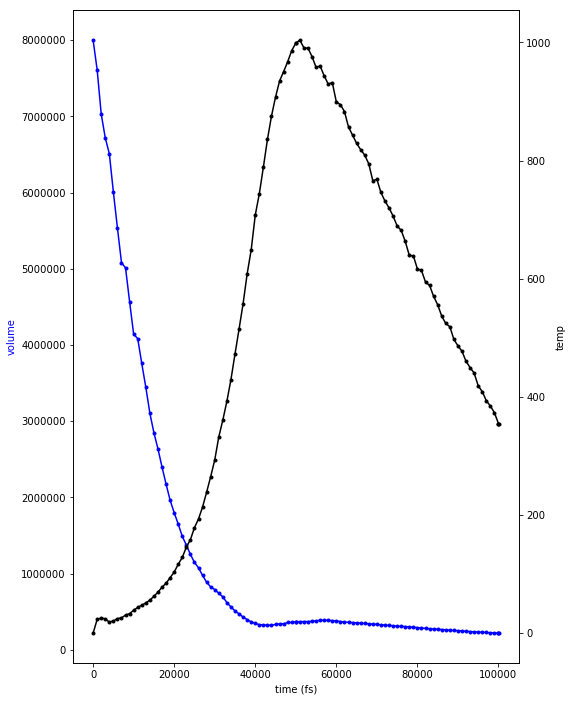

In [263]:
plot_mdrun(lmp_i)

Cool the volume is decreasing 

Note::
        If you want to collapse the system entirely you will have to run a slower cooling cycle

In [264]:
lmp_i.store()

In [265]:
lmp_i.pull()

Read in data file output and update positions

In [266]:
datafn = lmp_i.files['output']['data_3']
print datafn

equ0.data


Update positions

In [267]:
lmp_i.read_data_pos(datafn)

Check the size of the simulation cell

In [268]:
print lmp_i.strucC.lat.matrix

[[ 60.25290351   0.           0.        ]
 [  0.          60.25290351   0.        ]
 [  0.           0.          60.25290351]]


Update tag

In [269]:
lmp_i.strucC.tag += '_equ0'

In [270]:
lmp_i.strucC.write_xyz()

We can use streamm to calculate some properties of the system

In [271]:
lmp_i.strucC.calc_mass()
lmp_i.strucC.calc_volume()
lmp_i.strucC.calc_center_mass()

In [272]:
print lmp_i.strucC.center_mass

[ 1.879089    3.80707676 -1.2714102 ]


In [273]:
struc_i = lmp_i.strucC

Save annealed structure 

In [274]:
os.chdir(res_local.dir['materials'])
struc_json = struc_i.export_json()

Let us create a new project to hold all the ET calculations we need to do for each pair of groups

In [320]:
mol_et_equ0 = streamm.Project('mol_et_equ0')

In [321]:
mol_et_equ0.set_resource(res_local)

In [322]:
os.chdir(mol_et_equ0.dir['materials'])

If we need to restart the project here all we have to do is load in the structure 

In [323]:
try:
    print  struc_i.n_particles
except:
    struc_i = streamm.Buildingblock('p3HTx50_equ0')
    struc_i.import_json()

6350


Create groups out of the molecules

In [324]:
groupset_i = streamm.Groups('mol',struc_i)

In [325]:
groupset_i.group_prop('mol','oligomers')

In [326]:
print len(groupset_i.groups)

50


In [327]:
groupset_i.strucC.lat.pbcs = [True,True,True]

In [328]:
print groupset_i.strucC.lat.pbcs

[True, True, True]


In [329]:
print groupset_i.strucC.lat.matrix

[[ 60.25290351   0.           0.        ]
 [  0.          60.25290351   0.        ]
 [  0.           0.          60.25290351]]


Apply periodic boundaries to all the groups, so the molecules are not split across pbc's

In [330]:
groupset_i.group_pbcs()

In [331]:
lmp_i.strucC.calc_center_mass()

In [332]:
print lmp_i.strucC.center_mass

[ 3.00867262  4.93687616 -2.68781403]


Write out the new structure and check that all the molecules are whole 

In [333]:
groupset_i.strucC.write_xyz('groups.xyz')

Calculate some group properties to use to build a neighbor list 

In [334]:
groupset_i.calc_cent_mass()
groupset_i.calc_radius()
# groupset_i.calc_dl()

In [335]:
print groupset_i.strucC.lat
print len(groupset_i.cent_mass)
print len(groupset_i.radius)

60.252904 0.000000 0.000000
0.000000 60.252904 0.000000
0.000000 0.000000 60.252904
50
50


Save the structure we are creating our pairs from 

In [336]:
gmol_json = groupset_i.strucC.export_json()

Create a neighbor list of groups 

In [337]:
groupset_i.group_nblist.radii_nblist(groupset_i.strucC.lat,groupset_i.cent_mass,groupset_i.radius,radii_buffer=0.500)

In [338]:
print groupset_i.group_nblist

 NBlist of 50 particles with 146 connections


In [339]:
g_nbs = []
for gk_i,g_i in groupset_i.groups.iteritems():
        n_nbs = groupset_i.group_nblist.calc_nnab(gk_i)
        g_nbs.append(n_nbs)
g_nbs = np.array(g_nbs)    

Check the min, average and max numbers of neighbors

In [340]:
print g_nbs.min(),g_nbs.mean(),g_nbs.max()

0 2.92 5


Loop over each group, shift the group to the center of the simulation cell and write an .xyz file that includes the neighbors of the group.

In [341]:
for gk_i,g_i in groupset_i.groups.iteritems():
        list_i = copy.deepcopy(g_i.pkeys)
        for g_j in groupset_i.group_nblist.getnbs(gk_i):
            list_i += groupset_i.groups[g_j].pkeys
        print gk_i,groupset_i.group_nblist.calc_nnab(gk_i),len(list_i)
        groupset_i.strucC.shift_pos(-1.0*g_i.cent_mass)  # Place center of mass at origin
        groupset_i.strucC.write_xyz_list(list_i,xyz_file='nn_{}.xyz'.format(gk_i))
        groupset_i.strucC.shift_pos(g_i.cent_mass)  # Return center of mass 
        
        list_i = []
        

0 5 762
1 4 635
2 3 508
3 3 508
4 2 381
5 4 635
6 3 508
7 4 635
8 1 254
9 2 381
10 2 381
11 4 635
12 3 508
13 1 254
14 2 381
15 2 381
16 4 635
17 4 635
18 2 381
19 2 381
20 1 254
21 1 254
22 4 635
23 4 635
24 1 254
25 3 508
26 2 381
27 4 635
28 2 381
29 4 635
30 5 762
31 3 508
32 5 762
33 3 508
34 0 127
35 2 381
36 3 508
37 3 508
38 1 254
39 4 635
40 3 508
41 3 508
42 4 635
43 2 381
44 2 381
45 4 635
46 2 381
47 5 762
48 5 762
49 4 635


The nearest neighbor cluster look good so let us calculate the electron transfer 

First create a list of unique pairs 

In [342]:
et_pairs = {}
et_pairs['i'] = []
et_pairs['j'] = []
for gk_i,g_i in groupset_i.groups.iteritems():
    for gk_j in groupset_i.group_nblist.getnbs(gk_i):
        if( gk_j > gk_i ):
            et_pairs['i'].append(gk_i)
            et_pairs['j'].append(gk_j)
            
            

Convert the dictionary to a pandas Dataframe

In [343]:
import pandas as pd

In [349]:
et_df = pd.DataFrame(et_pairs)

In [350]:
et_df.columns

Index([], dtype='object')

Save that in a local file 

In [352]:
et_fn = 'et_pairs.csv'
if( len(et_df) == 0 ):
    et_df = pd.read_csv(et_fn)

In [353]:
print  len(et_df)

71


In [354]:
et_df.to_csv('et_pairs.csv',sep=',')

In [355]:
def nw_et(project_i,res_i,groupset_i,gk_i,gk_j,run_calc = True):

    calc_n =  len(project_i.calculations)     
    nwchem_et = streamm.NWChem('nw_et_{}_g{}_g{}'.format(project_i.tag,gk_i,gk_j))

    # Set calculation to run on external resource
    nwchem_et.set_resource(res_i)

    # Make the local directories 
    nwchem_et.make_dir()
    # Change to the `launch` directory
    os.chdir(nwchem_et.dir['launch'])

    group_i = groupset_i.groups[gk_i]
    group_j = groupset_i.groups[gk_j]    

    nwchem_et.properties['coord_i'] = group_i.write_coord()
    nwchem_et.properties['coord_j'] = group_j.write_coord()    
    nwchem_et.properties['coord_ij'] = nwchem_et.properties['coord_i'] + nwchem_et.properties['coord_j'] 
    
    

    nwchem_et.cp_file('templates','run',"nwchem_remote.pbs",'templates','launch')
    nwchem_et.cp_file('templates','nw',"nwchem_et.nw",'templates','launch')
    #
    nwchem_et.load_str('templates','nw')        
    nwchem_et.load_str('templates','run')
    # 
    nwchem_et.replacewrite_prop('nw','input','nw','%s.nw'%(nwchem_et.tag))

    nwchem_et.properties['input_nw'] = nwchem_et.files['input']['nw']
    nwchem_et.replacewrite_prop('run','scripts','run','%s.pbs'%(nwchem_et.tag))

    nwchem_et.add_file('output','log',"%s.log"%(nwchem_et.tag))
    # Save details in .json files 
    # 
    os.chdir(nwchem_et.dir['home'])
    nwchem_et.export_json()
    # 
    #
    if( run_calc ):
        os.chdir(nwchem_et.dir['launch'])
        nwchem_et.push()
        nwchem_et.run()
        
    return nwchem_et


Loop over all the pairs and create NWChem ET input files

In [356]:
et_df['calc_id'] = None

In [377]:
for k,pair_i in et_df.iterrows():
    gk_i = pair_i['i']
    gk_j = pair_i['j']
    nwchem_et = nw_et(mol_et_equ0,res_calc,groupset_i,gk_i,gk_j)
    # Add calculation to project
    mol_et_equ0.add_calc(nwchem_et,deepcopy = True)    
    # Add the tag to the Dataframe 
    #
    et_row = et_df.loc[ (et_df['i'] == gk_i ) & (et_df['j'] == gk_j)]
    et_index =  int(et_row.index[0])
    et_df.loc[et_index,'calc_id'] = nwchem_et.tag

Check the first couple of entries in the Dataframe 

In [378]:
et_df.head()

,Unnamed: 0,i,j,calc_id
0,0,0,3,nw_et_mol_et_equ0_g0_g3
1,1,0,14,nw_et_mol_et_equ0_g0_g14
2,2,0,15,nw_et_mol_et_equ0_g0_g15
3,3,0,19,nw_et_mol_et_equ0_g0_g19
4,4,0,43,nw_et_mol_et_equ0_g0_g43


In [379]:
os.chdir(mol_et_equ0.dir['home'])
et_json = mol_et_equ0.export_json()

Now we have to wait for all of these calculations to finish

In [380]:
import sys 

In [386]:
calcsrunning = True 
while( calcsrunning ):
    calcsrunning = False 
    n_running = 0 
    for k,calc_i in mol_et_equ0.calculations.iteritems():
        os.chdir(calc_i.dir['launch'])
        calc_i.check()
        if( calc_i.meta['status'] == 'finished' ):
            n_running += 1
        else:
            calcsrunning = True 
    sys.stdout.write("progress: {}/{} \r".format(n_running,len(mol_et_equ0.calculations)))
    sys.stdout.flush()
    time.sleep(status_refresh)

Run analysis on the results 

S_ij is the Reactants/Products overlap between group i and group j and V_ij is the Electron Transfer Coupling Energy between groups i and j. 

In [387]:
et_df['S_ij'] = None
et_df['S_ji'] = None
et_df['V_ij'] = None
et_df['V_ji'] = None

In [388]:
for k,calc_i in mol_et_equ0.calculations.iteritems():
    if(  calc_i.meta['status'] == 'finished' ):

        print calc_i.tag,calc_i.meta['status'] 
        os.chdir(calc_i.dir['launch'])

        et_row = et_df.loc[ et_df['calc_id'] == calc_i.tag ]
        
        et_index =  int(et_row.index[0])
        calc_i.store()
        calc_i.pull()
        calc_i.analysis()

        if( len(calc_i.et_list) > 0  ):
            et_df.loc[et_index,'S_ij'] = calc_i.et_list[0].S
            et_df.loc[et_index,'V_ij'] = calc_i.et_list[0].V
            et_df.loc[et_index,'S_ji'] = calc_i.et_list[1].S
            et_df.loc[et_index,'V_ji'] = calc_i.et_list[1].V


        calc_i.store()


nw_et_mol_et_equ0_g14_g45 finished
nw_et_mol_et_equ0_g10_g49 finished
nw_et_mol_et_equ0_g43_g45 finished
nw_et_mol_et_equ0_g12_g18 finished
nw_et_mol_et_equ0_g1_g44 finished
nw_et_mol_et_equ0_g8_g38 finished
nw_et_mol_et_equ0_g9_g23 finished
nw_et_mol_et_equ0_g39_g41 finished
nw_et_mol_et_equ0_g0_g15 finished
nw_et_mol_et_equ0_g0_g14 finished
nw_et_mol_et_equ0_g38_g48 finished
nw_et_mol_et_equ0_g0_g19 finished
nw_et_mol_et_equ0_g14_g49 finished
nw_et_mol_et_equ0_g20_g40 finished
nw_et_mol_et_equ0_g0_g49 finished
nw_et_mol_et_equ0_g23_g25 finished
nw_et_mol_et_equ0_g7_g11 finished
nw_et_mol_et_equ0_g3_g38 finished
nw_et_mol_et_equ0_g15_g48 finished
nw_et_mol_et_equ0_g4_g39 finished
nw_et_mol_et_equ0_g4_g12 finished
nw_et_mol_et_equ0_g37_g49 finished
nw_et_mol_et_equ0_g0_g43 finished
nw_et_mol_et_equ0_g6_g35 finished
nw_et_mol_et_equ0_g1_g28 finished
nw_et_mol_et_equ0_g10_g37 finished
nw_et_mol_et_equ0_g10_g36 finished
nw_et_mol_et_equ0_g32_g45 finished
nw_et_mol_et_equ0_g36_g45 finished

Check the values in the Dataframe

In [389]:
et_df

,Unnamed: 0,i,j,calc_id,S_ij,S_ji,V_ij,V_ji
0,0,0,3,nw_et_mol_et_equ0_g0_g3,4.73e-06,4.73e-06,1.396e-07,1.396e-07
1,1,0,14,nw_et_mol_et_equ0_g0_g14,-1.09e-05,-1.09e-05,6.5729e-06,6.5729e-06
2,2,0,15,nw_et_mol_et_equ0_g0_g15,-8.07e-06,-8.07e-06,4.211e-06,4.211e-06
3,3,0,19,nw_et_mol_et_equ0_g0_g19,-3.32e-05,-3.32e-05,1.65649e-05,1.65649e-05
4,4,0,43,nw_et_mol_et_equ0_g0_g43,0,4.36e-19,inf,0.0310552
5,5,0,49,nw_et_mol_et_equ0_g0_g49,0,1.04e-18,NaN,0.0260748
6,6,1,16,nw_et_mol_et_equ0_g1_g16,-0.000259,-0.000259,0.000202278,0.000202278
7,7,1,17,nw_et_mol_et_equ0_g1_g17,0,1.2e-19,NaN,0.113202
8,8,1,28,nw_et_mol_et_equ0_g1_g28,0,-5.59e-20,inf,0
9,9,1,33,nw_et_mol_et_equ0_g1_g33,0,1.05e-19,NaN,0


Remove `inf` and `NaN` values 

In [390]:
et_c1 = et_df.replace([np.inf], np.nan)

In [391]:
et_c1.dropna()

,Unnamed: 0,i,j,calc_id,S_ij,S_ji,V_ij,V_ji
0,0,0,3,nw_et_mol_et_equ0_g0_g3,4.730000e-06,4.730000e-06,1.396000e-07,1.396000e-07
1,1,0,14,nw_et_mol_et_equ0_g0_g14,-1.090000e-05,-1.090000e-05,6.572900e-06,6.572900e-06
2,2,0,15,nw_et_mol_et_equ0_g0_g15,-8.070000e-06,-8.070000e-06,4.211000e-06,4.211000e-06
3,3,0,19,nw_et_mol_et_equ0_g0_g19,-3.320000e-05,-3.320000e-05,1.656490e-05,1.656490e-05
6,6,1,16,nw_et_mol_et_equ0_g1_g16,-2.590000e-04,-2.590000e-04,2.022779e-04,2.022779e-04
10,10,1,44,nw_et_mol_et_equ0_g1_g44,-4.640000e-07,-4.640000e-07,2.598000e-07,2.598000e-07
11,11,2,31,nw_et_mol_et_equ0_g2_g31,4.430000e-05,4.430000e-05,9.710200e-06,9.710200e-06
12,12,2,32,nw_et_mol_et_equ0_g2_g32,-2.390000e-05,-2.390000e-05,1.554690e-05,1.554690e-05
13,13,2,47,nw_et_mol_et_equ0_g2_g47,9.570000e-05,9.570000e-05,4.788100e-05,4.788100e-05
15,15,4,12,nw_et_mol_et_equ0_g4_g12,-4.790000e-05,-4.790000e-05,3.430910e-05,3.430910e-05


In [392]:
print et_c1['V_ij'].min(),et_c1['V_ij'].mean(),et_c1['V_ij'].max()

2.37e-08 9.37995884615e-05 0.0010632199


We can take a look at the histogram of magnitudes of V_ij

In [393]:
et_c1['log_V_ij'] = np.log10(et_c1['V_ij'])

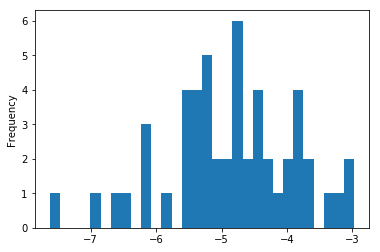

In [394]:
et_c1['log_V_ij'].plot.hist(bins=30,alpha=1.0)

Just calculated the inter-molecular electronic coupling between P3ht

Boom!

There is a stripped down python version of this example (P3HT_ET.py) that will run the calculations on external resource 